In [ ]:
# Capstone stuff when my laptop was broken
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Testing Cutoffs ANN 0

In [ ]:
# No. outputs
outputs = 1

# Files must be the same length
ANN_paths = ['/content/drive/MyDrive/Colab Notebooks/LINER/LINER_ANN_3.keras', '/content/drive/MyDrive/Colab Notebooks/LINER/LINER_ANN_4.keras', '/content/drive/MyDrive/Colab Notebooks/LINER/LINER_ANN_5.keras', '/content/drive/MyDrive/Colab Notebooks/LINER/LINER_ANN_6.keras']
file_paths = ['/content/drive/MyDrive/Colab Notebooks/LINER/LINER_10_to_37_mod.txt', '/content/drive/MyDrive/Colab Notebooks/LINER/LINER_10_to_37_mod.txt', '/content/drive/MyDrive/Colab Notebooks/LINER/LINER_10_to_37_mod.txt', '/content/drive/MyDrive/Colab Notebooks/LINER/LINER_10_to_37_mod.txt']

lines_present = []
status = []

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    data = np.loadtxt(file)

    test_data = data[:,:-outputs] # The amplitudes
    lines = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # YPred is the predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    # Separate the lines into the different categories
    lines = lines.T

    lines_present.append(lines.T)

    status.append(lines - YPred)

lines_present = np.array(lines_present)[:,0]
status = np.array(status).T[0]

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
# The cutoff for what is considered a line
cutoffs = np.arange(0.001, 1.001, 0.001)

# Store values
tp = np.empty((len(status[0]), len(cutoffs)))
fp = np.empty((len(status[0]), len(cutoffs)))
fn = np.empty((len(status[0]), len(cutoffs)))
tn = np.empty((len(status[0]), len(cutoffs)))

# Loop over cutoff values
for j in range(len(cutoffs)):
    # Loop over sets of data
    for i in range(len(status[0])):
      real_det = np.dstack(np.where((status[:,i] >= 0) & (status[:,i] <= 1 - cutoffs[j])))[0]
      miss_det = np.dstack(np.where(status[:,i] > 1 - cutoffs[j]))[0]
      nothing = np.dstack(np.where((status[:,i] > 0 - cutoffs[j]) & (status[:,i] < 0)))[0]
      false_pos = np.dstack(np.where(status[:,i] <= 0 - cutoffs[j]))[0]

      # Confusion matrix overall
      confusion = np.array([[len(real_det), len(false_pos)], [len(miss_det), len(nothing)]], dtype='f')

      # Relative values
      no_false, no_lines = np.unique(lines_present[i], return_counts=True)[1]

      confusion[:,0] /= no_lines
      confusion[:,1] /= no_false

      tp[i,j] = confusion[0,0]
      fp[i,j] = confusion[0,1]
      fn[i,j] = confusion[1,0]
      tn[i,j] = confusion[1,1]

[0.512 0.541 0.491 0.679]
Cutoff with minimal incorrect classifciation for LINER : 0.512
False negatives at this cutoff for LINER: 0.1253928542137146
False positives at this cutoff for LINER: 0.03157142922282219

Cutoff with minimal incorrect classifciation for Seyfert : 0.541
False negatives at this cutoff for Seyfert: 0.13167856633663177
False positives at this cutoff for Seyfert: 0.026607142761349678

Cutoff with minimal incorrect classifciation for Star forming : 0.491
False negatives at this cutoff for Star forming: 0.12150000035762787
False positives at this cutoff for Star forming: 0.04085714370012283

Cutoff with minimal incorrect classifciation for Planetary nebula : 0.679
False negatives at this cutoff for Planetary nebula: 0.1456071436405182
False positives at this cutoff for Planetary nebula: 0.027321428060531616

Overall minimal incorrect classifciation
Cutoff with minimal incorrect classifciation: 0.514
False negatives at this cutoff for LINER: 0.12575000524520874
False p

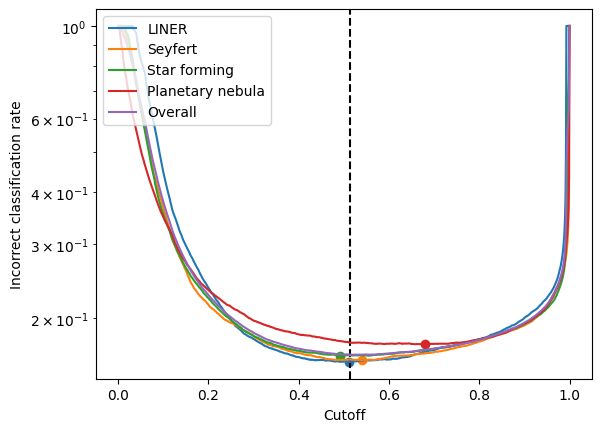

In [ ]:
# Find indices where incorrect classification is minimised

mins = np.array([], dtype=int)
min_overall = np.argmin(np.mean(fn + fp, axis=0))

for i in range(len(fn)):
    mins = np.append(mins, np.argmin(fn[i] + fp[i]))

print(cutoffs[mins])

types = ['LINER', 'Seyfert', 'Star forming', 'Planetary nebula']

for i in range(len(fn)):
  print(f'Cutoff with minimal incorrect classifciation for {types[i]} : {cutoffs[mins[i]]}')
  print(f'False negatives at this cutoff for {types[i]}: {fn[i][mins[i]]}')
  print(f'False positives at this cutoff for {types[i]}: {fp[i][mins[i]]}\n')
  plt.scatter(cutoffs[mins[i]], (fn + fp)[i][mins[i]])

print('Overall minimal incorrect classifciation')
print(f'Cutoff with minimal incorrect classifciation: {cutoffs[min_overall]}')
for i in range(len(fn)):
  print(f'False negatives at this cutoff for {types[i]}: {fn[i][min_overall]}')
  print(f'False positives at this cutoff for {types[i]}: {fp[i][min_overall]}\n')

plt.axvline(cutoffs[min_overall], color='black', linestyle='--')


plt.plot(cutoffs, fp[0] + fn[0], label='LINER')
plt.plot(cutoffs, fp[1] + fn[1], label='Seyfert')
plt.plot(cutoffs, fp[2] + fn[2], label='Star forming')
plt.plot(cutoffs, fp[3] + fn[3], label='Planetary nebula')
plt.plot(cutoffs, np.mean(fn+fp, axis=0), label='Overall')
plt.yscale('log')
plt.xlabel('Cutoff')
plt.ylabel('Incorrect classification rate')
plt.legend(loc=2)
plt.show()

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


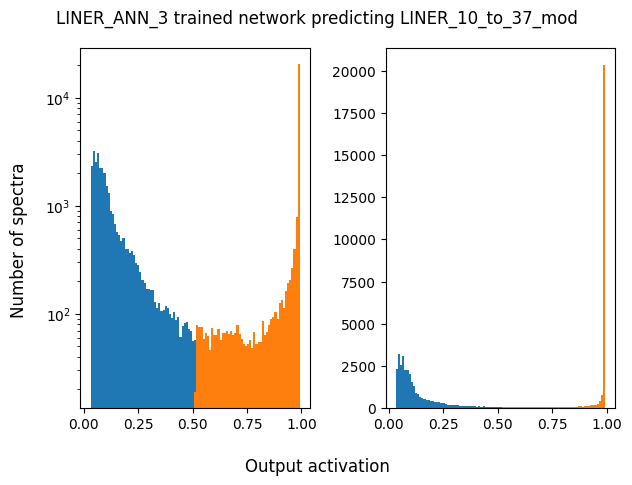

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


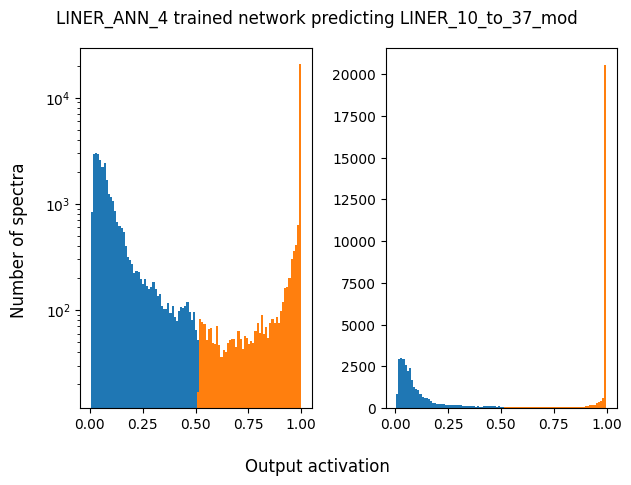

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


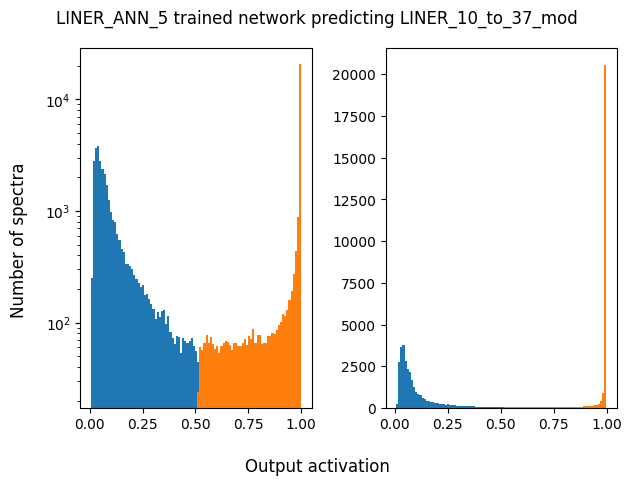

 216/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

In [ ]:
# The cutoff for what is considered a line
cutoff = cutoffs[min_overall]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    data = np.loadtxt(file)

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    test_data = data[:,:-outputs] # The amplitudes
    lines_present = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # YPred is the predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    predicted_data = np.hstack((test_data, YPred))

    # Highlighting potential hits
    potential = predicted_data[np.unique(np.where(YPred > cutoff)[0]),:]

    # Create histograms for each peak
    hbin = np.linspace(min(YPred), max(YPred), num=100).reshape(-1)
    fig, ax = plt.subplots(1, 2)

    for j in range(2):
        ax[j].hist(YPred[np.where(YPred < cutoff)[0]], bins=hbin, density=False, label='Non-Detections')
        ax[j].hist(YPred[np.where(YPred > cutoff)[0]], bins=hbin, density=False, label='Potential Detections')

    fig.supxlabel('Output activation')
    fig.supylabel('Number of spectra')

    fig.suptitle(f'{ANN_name} trained network predicting {test_name}')
    ax[0].set_yscale('log')
    ax[1].set_yscale('linear')
    plt.tight_layout()
    plt.show()

In [ ]:
cutoff = cutoffs[min_overall]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    data = np.loadtxt(file)

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    # Best overall
    # Confusion matrix
    confusion = np.array([[tp[i,min_overall], fp[i,min_overall]], [fn[i,min_overall], tn[i,min_overall]]], dtype='f')

    ax = plt.gca()
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.imshow(confusion, cmap='Greys', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks([0, 1], ['Spectrum present', 'Spectrum not present'])
    plt.yticks([0, 1], ['Spectrum detected', 'Spectrum not detected'], rotation='vertical', va='center')
    plt.ylabel('Is the line detected?')
    plt.xlabel('Is the line present?')
    plt.title(f'Confusion matrix for all lines in {test_name}\nusing {ANN_name}, overall best')
    plt.text(0, 0, np.round(confusion[0][0], 5), ha='center', backgroundcolor='w')
    plt.text(0, 1, np.round(confusion[1][0], 5), ha='center', backgroundcolor='w')
    plt.text(1, 0, np.round(confusion[0][1], 5), ha='center', backgroundcolor='yellow')
    plt.text(1, 1, np.round(confusion[1][1], 5), ha='center', backgroundcolor='w')
    plt.show()

    # Best locally
    # Confusion matrix
    confusion = np.array([[tp[i,mins[i]], fp[i,mins[i]]], [fn[i,mins[i]], tn[i,mins[i]]]], dtype='f')

    ax = plt.gca()
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.imshow(confusion, cmap='Greys', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks([0, 1], ['Spectrum present', 'Spectrum not present'])
    plt.yticks([0, 1], ['Spectrum detected', 'Spectrum not detected'], rotation='vertical', va='center')
    plt.ylabel('Is the line detected?')
    plt.xlabel('Is the line present?')
    plt.title(f'Confusion matrix for all lines in {test_name}\nusing {ANN_name}, local best')
    plt.text(0, 0, np.round(confusion[0][0], 5), ha='center', backgroundcolor='w')
    plt.text(0, 1, np.round(confusion[1][0], 5), ha='center', backgroundcolor='w')
    plt.text(1, 0, np.round(confusion[0][1], 5), ha='center', backgroundcolor='yellow')
    plt.text(1, 1, np.round(confusion[1][1], 5), ha='center', backgroundcolor='w')
    plt.show()

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


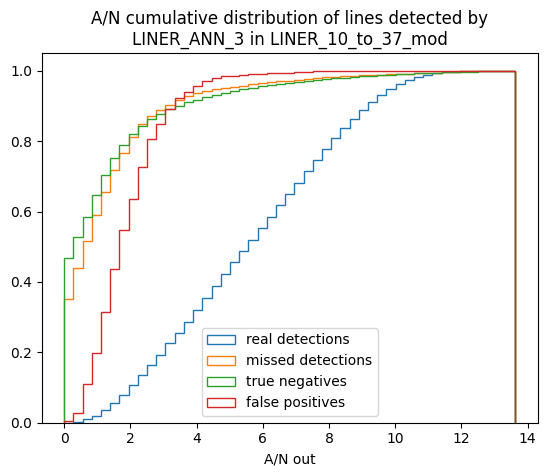

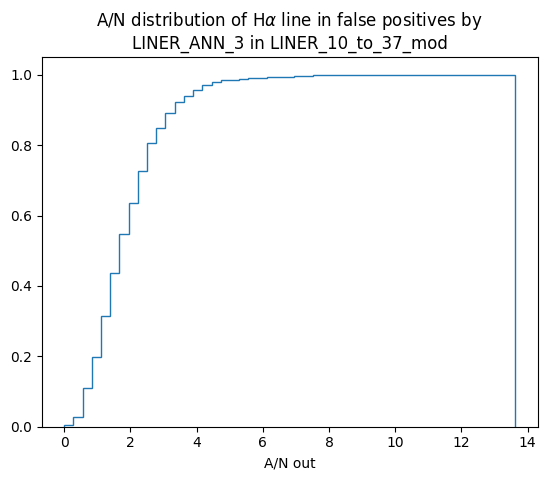

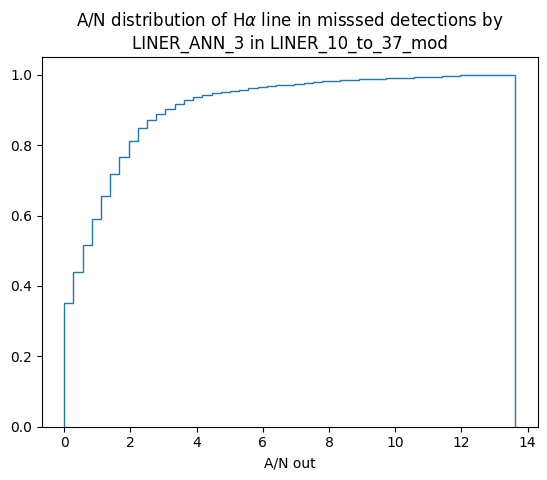

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


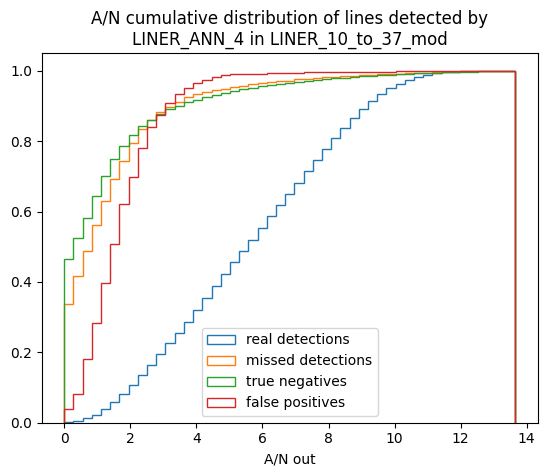

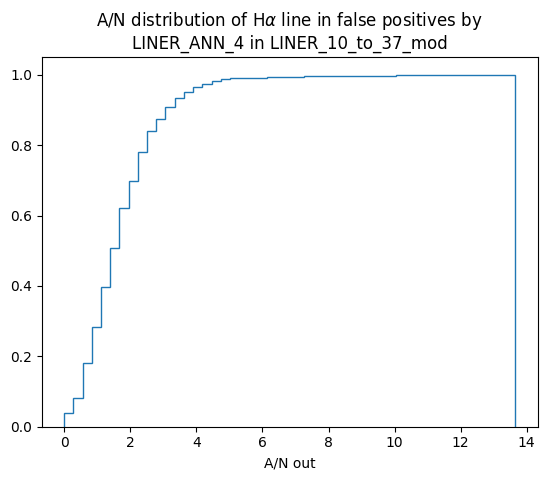

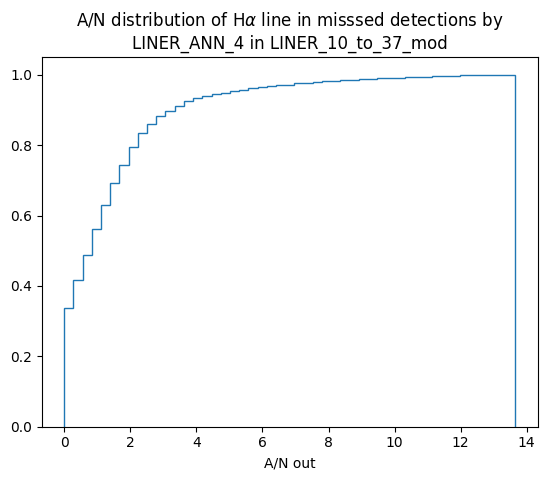

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


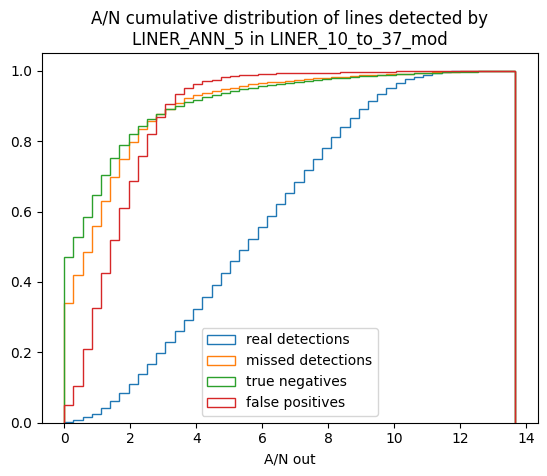

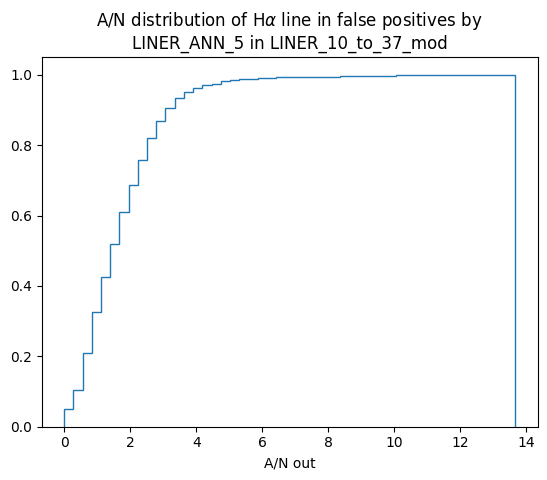

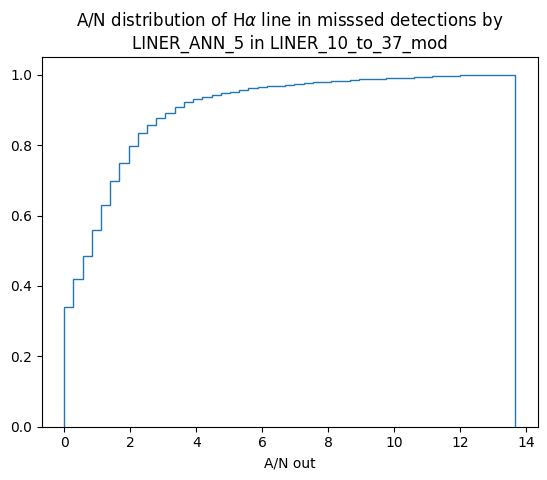

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


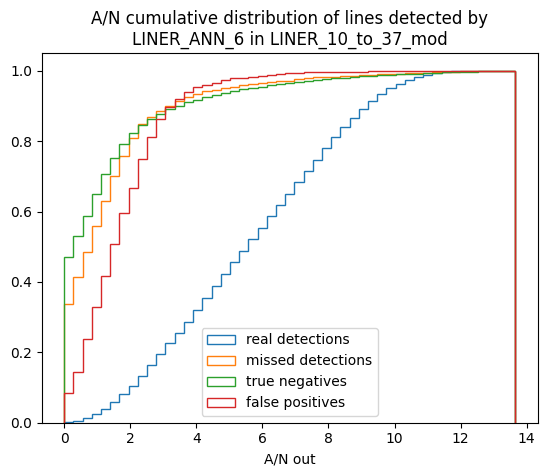

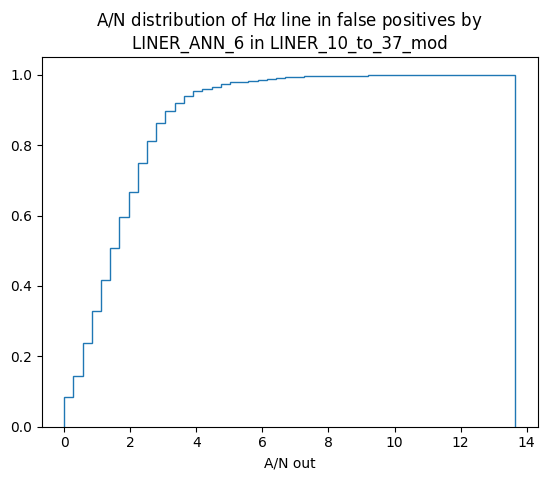

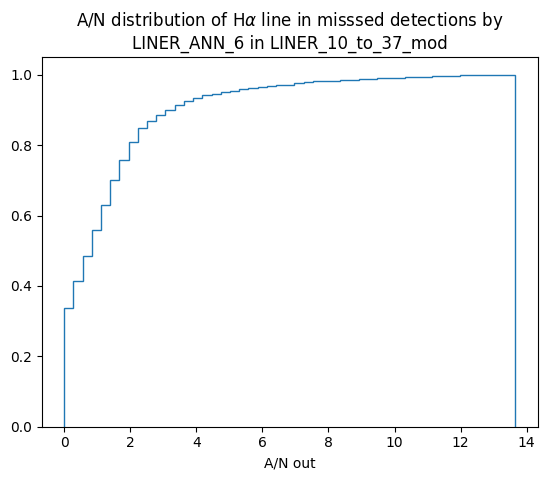

In [ ]:
# At what ANN does it work best
cutoff = cutoffs[min_overall]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    data = np.loadtxt(file)

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]


    test_data = data[:,:-outputs] # The amplitudes
    lines_present = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # The predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    # Separate the lines into the different categories and store AoNs
    lines_present = lines_present.T

    status = lines_present - YPred


    real_det = np.dstack(np.where((status >= 0) & (status <= 1 - cutoff)))[0]
    miss_det = np.dstack(np.where(status > 1 - cutoff))[0]
    nothing = np.dstack(np.where((status > 0 - cutoff) & (status < 0)))[0]
    false_pos = np.dstack(np.where(status <= 0 - cutoff))[0]

    if outputs != 1:
        real_AoNs = data[real_det[:,0], real_det[:,1]]
        miss_AoNs = data[miss_det[:,0], miss_det[:,1]]
        noth_AoNs = data[nothing[:,0], nothing[:,1]]
        false_AoNs = data[false_pos[:,0], false_pos[:,1]]
    else:
        real_AoNs = data[real_det[:,0], 4]
        miss_AoNs = data[miss_det[:,0], 4]
        noth_AoNs = data[nothing[:,0], 4]
        false_AoNs = data[false_pos[:,0], 4]

    # Create histograms
    density = True
    cumulative = True
    no_bins = 50

    hbin = np.linspace(0, np.median(real_AoNs) + 3*np.std(real_AoNs), no_bins)
    plt.hist(real_AoNs, bins=hbin, density=density, label='real detections', histtype='step', cumulative=cumulative)
    plt.hist(miss_AoNs, bins=hbin, density=density, label='missed detections', histtype='step', cumulative=cumulative)
    plt.hist(noth_AoNs, bins=hbin, density=density, label='true negatives', histtype='step', cumulative=cumulative)
    plt.hist(false_AoNs, bins=hbin, density=density, label='false positives', histtype='step', cumulative=cumulative)

    if cumulative == True:
        plt.title(f'A/N cumulative distribution of lines detected by\n{ANN_name} in {test_name}')
    else:
        plt.title(f'A/N distribution of lines detected by\n{ANN_name} in {test_name}')
    plt.xlabel('A/N out')
    plt.legend()
    plt.show()

    # The A/N of the false positives
    false_AoNs = data[false_pos[:,0], 4]

    plt.hist(false_AoNs, bins=hbin, density=density, histtype='step', cumulative=cumulative)
    plt.title(r'A/N distribution of H$\alpha$'+f' line in false positives by\n{ANN_name} in {test_name}')
    plt.xlabel('A/N out')
    plt.show()

    # The A/N of the undetected spectra
    missed_AoNs = data[miss_det[:,0], 4]

    plt.hist(missed_AoNs, bins=hbin, density=density, histtype='step', cumulative=cumulative)
    plt.title(r'A/N distribution of H$\alpha$'+f' line in misssed detections by\n{ANN_name} in {test_name}')
    plt.xlabel('A/N out')
    plt.show()

In [ ]:
for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]


    print(f'{ANN_name} & {np.round(fp[i, mins[i]]*100, 3)} & {np.round(fn[i, mins[i]]*100, 3)} & {cutoffs[mins[i]]} & 408 & 82 & 500 \\\\ ')

LINER_0_to_9_mod_ANN_0 & 3.293 & 14.193 & 0.649 & 408 & 82 & 500 \\ 
seyfert_0_to_9_mod_ANN_0 & 2.839 & 11.329 & 0.732 & 408 & 82 & 500 \\ 
star_forming_0_to_9_mod_ANN_0 & 9.443 & 22.939 & 0.58 & 408 & 82 & 500 \\ 
planetary_nebula_0_to_9_mod_ANN_0 & 3.3 & 8.246 & 0.589 & 408 & 82 & 500 \\ 


In [ ]:
filepath = os.path.splitext(file)[0]
name = filepath.split('/')[-1]
name = name.split('_')[0:-4]
if len(name) == 1:
    name = name[0]
else:
    name = '_'.join(name)

In [ ]:
filepath

'/content/drive/MyDrive/Colab Notebooks/planetary_nebula/planetary_nebula_10_to_37_mod'

In [ ]:
name

'planetary_nebula'

# Testing Cutoffs ANN 1

In [ ]:
# No. outputs
outputs = 1

# Files must be the same length
ANN_paths = ['/content/drive/MyDrive/Colab Notebooks/LINER/LINER_0_to_9_mod_ANN_1.keras', '/content/drive/MyDrive/Colab Notebooks/seyfert/seyfert_0_to_9_mod_ANN_1.keras', '/content/drive/MyDrive/Colab Notebooks/star_forming/star_forming_0_to_9_mod_ANN_1.keras', '/content/drive/MyDrive/Colab Notebooks/planetary_nebula/planetary_nebula_0_to_9_mod_ANN_1.keras']
file_paths = ['/content/drive/MyDrive/Colab Notebooks/LINER/LINER_10_to_37_mod.txt', '/content/drive/MyDrive/Colab Notebooks/seyfert/seyfert_10_to_37_mod.txt', '/content/drive/MyDrive/Colab Notebooks/star_forming/star_forming_10_to_37_mod.txt', '/content/drive/MyDrive/Colab Notebooks/planetary_nebula/planetary_nebula_10_to_37_mod.txt']

lines_present = []
status = []

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    data = np.loadtxt(file)

    test_data = data[:,:-outputs] # The amplitudes
    lines = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # YPred is the predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    # Separate the lines into the different categories
    lines = lines.T

    lines_present.append(lines.T)

    status.append(lines - YPred)

lines_present = np.array(lines_present)[:,0]
status = np.array(status).T[0]

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
# The cutoff for what is considered a line
cutoffs = np.arange(0.001, 1.001, 0.001)

# Store values
tp = np.empty((len(status[0]), len(cutoffs)))
fp = np.empty((len(status[0]), len(cutoffs)))
fn = np.empty((len(status[0]), len(cutoffs)))
tn = np.empty((len(status[0]), len(cutoffs)))

# Loop over cutoff values
for j in range(len(cutoffs)):
    # Loop over sets of data
    for i in range(len(status[0])):
      real_det = np.dstack(np.where((status[:,i] >= 0) & (status[:,i] <= 1 - cutoffs[j])))[0]
      miss_det = np.dstack(np.where(status[:,i] > 1 - cutoffs[j]))[0]
      nothing = np.dstack(np.where((status[:,i] > 0 - cutoffs[j]) & (status[:,i] < 0)))[0]
      false_pos = np.dstack(np.where(status[:,i] <= 0 - cutoffs[j]))[0]

      # Confusion matrix overall
      confusion = np.array([[len(real_det), len(false_pos)], [len(miss_det), len(nothing)]], dtype='f')

      # Relative values
      no_false, no_lines = np.unique(lines_present[i], return_counts=True)[1]

      confusion[:,0] /= no_lines
      confusion[:,1] /= no_false

      tp[i,j] = confusion[0,0]
      fp[i,j] = confusion[0,1]
      fn[i,j] = confusion[1,0]
      tn[i,j] = confusion[1,1]

[0.92  0.895 0.711 0.736]
Cutoff with minimal incorrect classifciation for LINER : 0.92
False negatives at this cutoff for LINER: 0.14225000143051147
False positives at this cutoff for LINER: 0.037785712629556656

Cutoff with minimal incorrect classifciation for Seyfert : 0.895
False negatives at this cutoff for Seyfert: 0.12153571099042892
False positives at this cutoff for Seyfert: 0.03246428444981575

Cutoff with minimal incorrect classifciation for Star forming : 0.711
False negatives at this cutoff for Star forming: 0.23357142508029938
False positives at this cutoff for Star forming: 0.10453571379184723

Cutoff with minimal incorrect classifciation for Planetary nebula : 0.736
False negatives at this cutoff for Planetary nebula: 0.09350000321865082
False positives at this cutoff for Planetary nebula: 0.03496428579092026

Overall minimal incorrect classifciation
Cutoff with minimal incorrect classifciation: 0.8290000000000001
False negatives at this cutoff for LINER: 0.132785707712

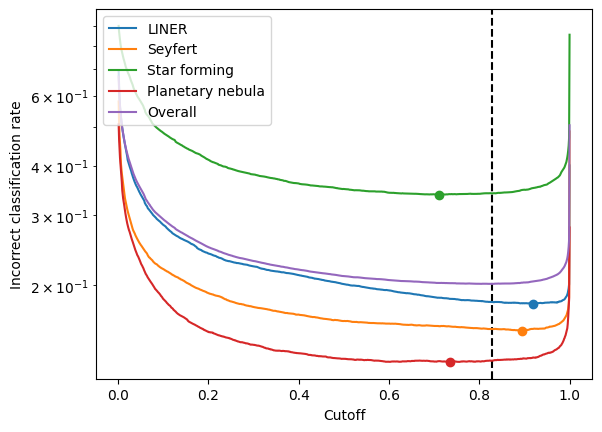

In [ ]:
# Find indices where incorrect classification is minimised

mins = np.array([], dtype=int)
min_overall = np.argmin(np.mean(fn + fp, axis=0))

for i in range(len(fn)):
    mins = np.append(mins, np.argmin(fn[i] + fp[i]))

print(cutoffs[mins])

types = ['LINER', 'Seyfert', 'Star forming', 'Planetary nebula']

for i in range(len(fn)):
  print(f'Cutoff with minimal incorrect classifciation for {types[i]} : {cutoffs[mins[i]]}')
  print(f'False negatives at this cutoff for {types[i]}: {fn[i][mins[i]]}')
  print(f'False positives at this cutoff for {types[i]}: {fp[i][mins[i]]}\n')
  plt.scatter(cutoffs[mins[i]], (fn + fp)[i][mins[i]])

print('Overall minimal incorrect classifciation')
print(f'Cutoff with minimal incorrect classifciation: {cutoffs[min_overall]}')
for i in range(len(fn)):
  print(f'False negatives at this cutoff for {types[i]}: {fn[i][min_overall]}')
  print(f'False positives at this cutoff for {types[i]}: {fp[i][min_overall]}\n')

plt.axvline(cutoffs[min_overall], color='black', linestyle='--')


plt.plot(cutoffs, fp[0] + fn[0], label='LINER')
plt.plot(cutoffs, fp[1] + fn[1], label='Seyfert')
plt.plot(cutoffs, fp[2] + fn[2], label='Star forming')
plt.plot(cutoffs, fp[3] + fn[3], label='Planetary nebula')
plt.plot(cutoffs, np.mean(fn+fp, axis=0), label='Overall')
plt.yscale('log')
plt.xlabel('Cutoff')
plt.ylabel('Incorrect classification rate')
plt.legend(loc=2)
plt.show()

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


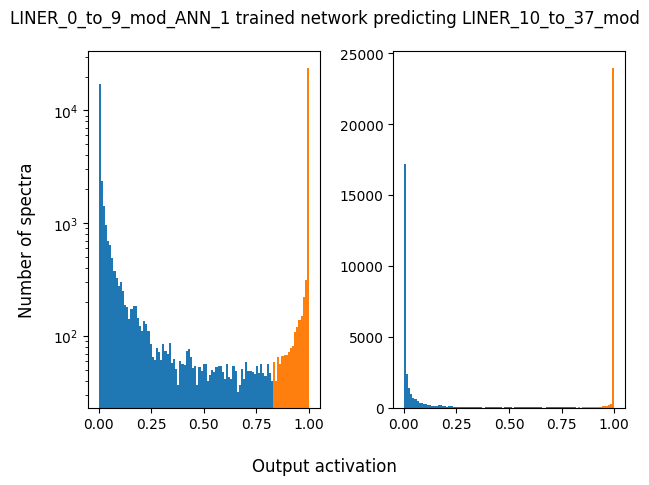

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


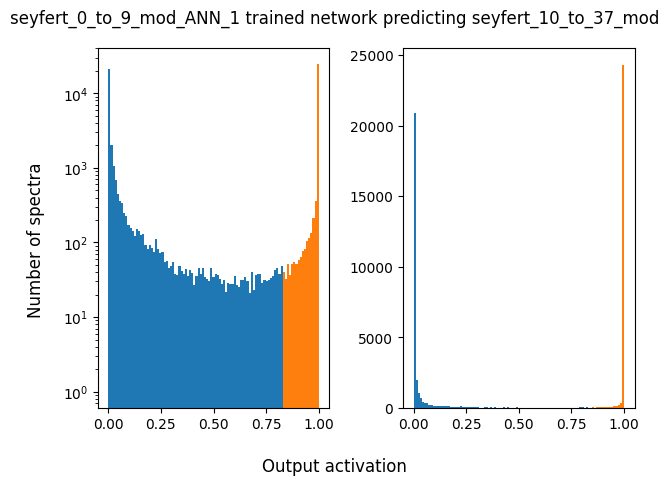

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


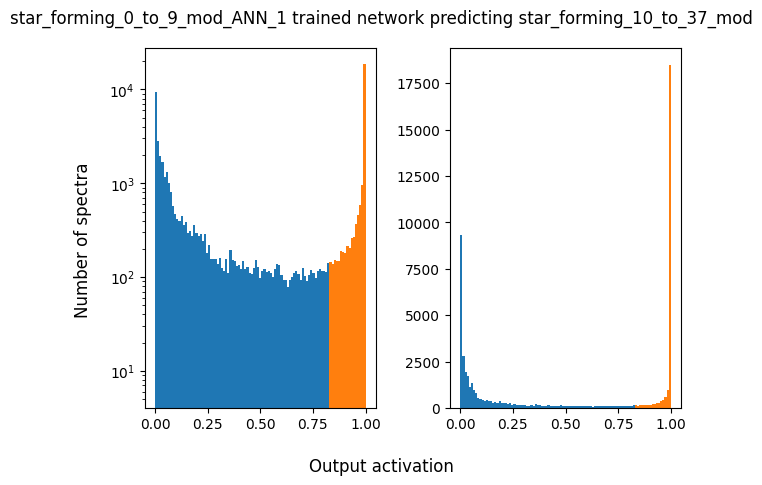

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


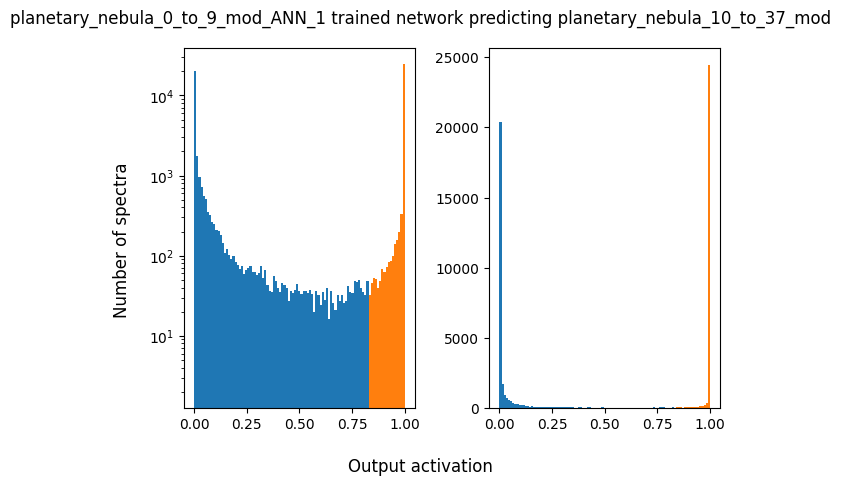

In [ ]:
# The cutoff for what is considered a line
cutoff = cutoffs[min_overall]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    data = np.loadtxt(file)

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    test_data = data[:,:-outputs] # The amplitudes
    lines_present = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # YPred is the predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    predicted_data = np.hstack((test_data, YPred))

    # Highlighting potential hits
    potential = predicted_data[np.unique(np.where(YPred > cutoff)[0]),:]

    # Create histograms for each peak
    hbin = np.linspace(min(YPred), max(YPred), num=100).reshape(-1)
    fig, ax = plt.subplots(1, 2)

    for j in range(2):
        ax[j].hist(YPred[np.where(YPred < cutoff)[0]], bins=hbin, density=False, label='Non-Detections')
        ax[j].hist(YPred[np.where(YPred > cutoff)[0]], bins=hbin, density=False, label='Potential Detections')

    fig.supxlabel('Output activation')
    fig.supylabel('Number of spectra')

    fig.suptitle(f'{ANN_name} network predicting {test_name}')
    ax[0].set_yscale('log')
    ax[1].set_yscale('linear')
    plt.tight_layout()
    plt.show()

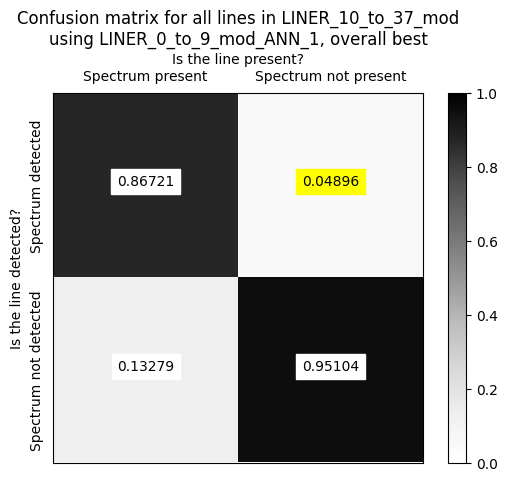

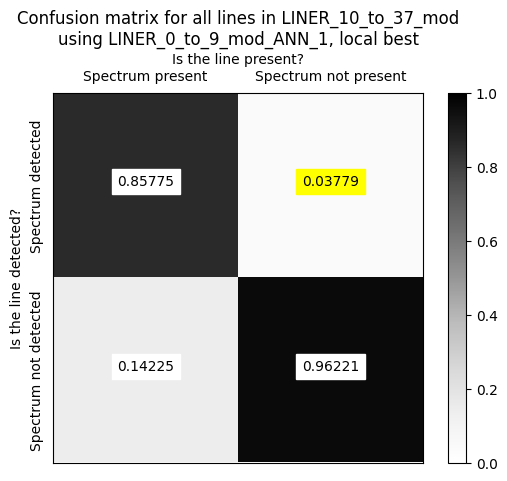

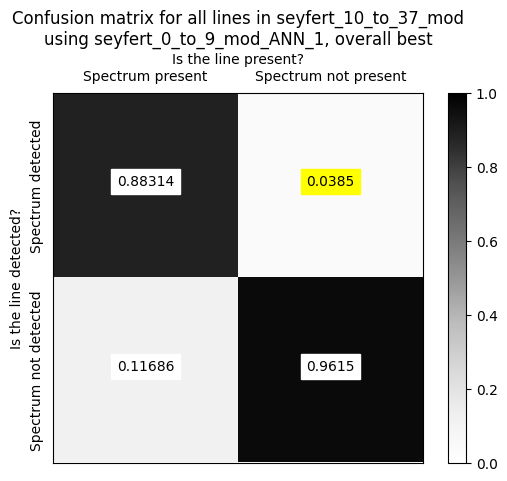

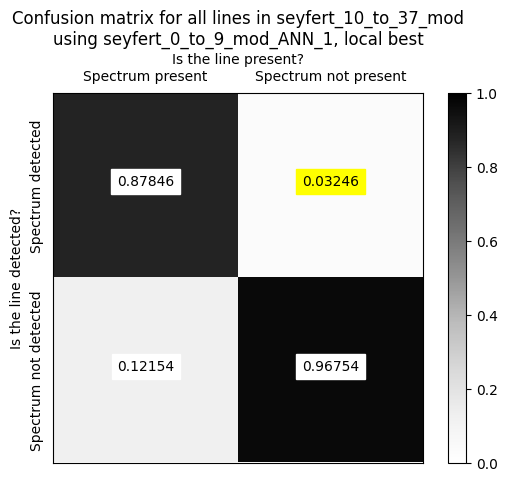

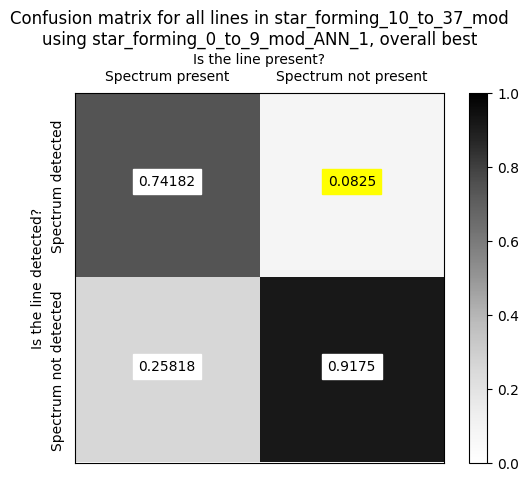

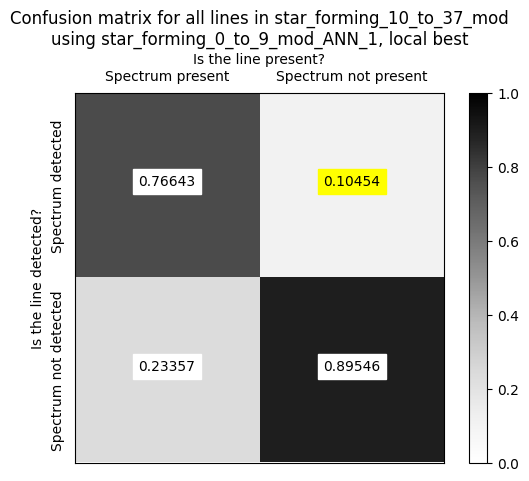

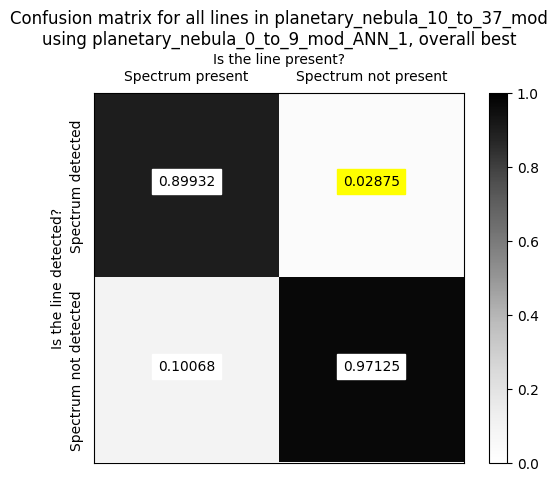

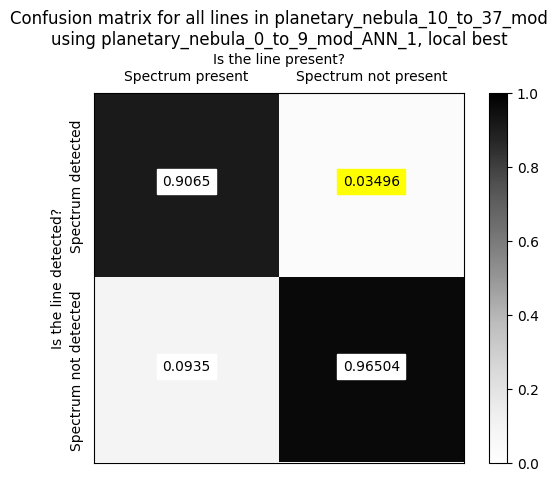

In [ ]:
cutoff = cutoffs[min_overall]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    data = np.loadtxt(file)

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    # Best overall
    # Confusion matrix
    confusion = np.array([[tp[i,min_overall], fp[i,min_overall]], [fn[i,min_overall], tn[i,min_overall]]], dtype='f')

    ax = plt.gca()
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.imshow(confusion, cmap='Greys', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks([0, 1], ['Spectrum present', 'Spectrum not present'])
    plt.yticks([0, 1], ['Spectrum detected', 'Spectrum not detected'], rotation='vertical', va='center')
    plt.ylabel('Is the line detected?')
    plt.xlabel('Is the line present?')
    plt.title(f'Confusion matrix for all lines in {test_name}\nusing {ANN_name}, overall best')
    plt.text(0, 0, np.round(confusion[0][0], 5), ha='center', backgroundcolor='w')
    plt.text(0, 1, np.round(confusion[1][0], 5), ha='center', backgroundcolor='w')
    plt.text(1, 0, np.round(confusion[0][1], 5), ha='center', backgroundcolor='yellow')
    plt.text(1, 1, np.round(confusion[1][1], 5), ha='center', backgroundcolor='w')
    plt.show()

    # Best locally
    # Confusion matrix
    confusion = np.array([[tp[i,mins[i]], fp[i,mins[i]]], [fn[i,mins[i]], tn[i,mins[i]]]], dtype='f')

    ax = plt.gca()
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.imshow(confusion, cmap='Greys', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks([0, 1], ['Spectrum present', 'Spectrum not present'])
    plt.yticks([0, 1], ['Spectrum detected', 'Spectrum not detected'], rotation='vertical', va='center')
    plt.ylabel('Is the line detected?')
    plt.xlabel('Is the line present?')
    plt.title(f'Confusion matrix for all lines in {test_name}\nusing {ANN_name}, local best')
    plt.text(0, 0, np.round(confusion[0][0], 5), ha='center', backgroundcolor='w')
    plt.text(0, 1, np.round(confusion[1][0], 5), ha='center', backgroundcolor='w')
    plt.text(1, 0, np.round(confusion[0][1], 5), ha='center', backgroundcolor='yellow')
    plt.text(1, 1, np.round(confusion[1][1], 5), ha='center', backgroundcolor='w')
    plt.show()

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


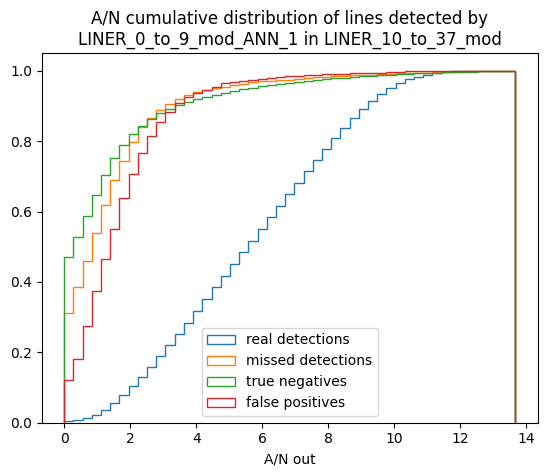

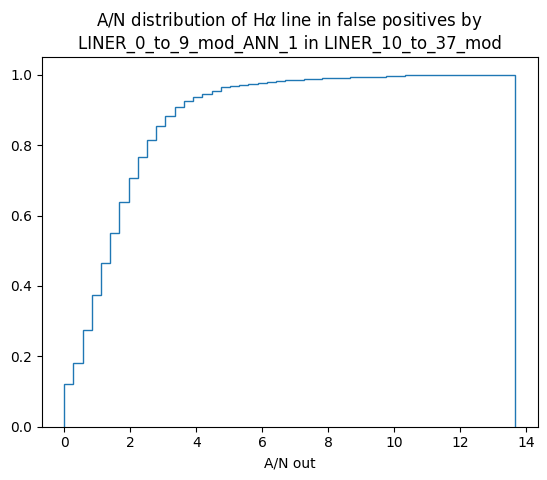

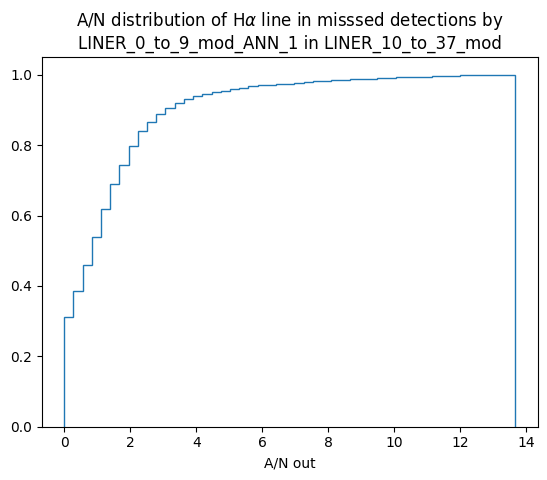

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


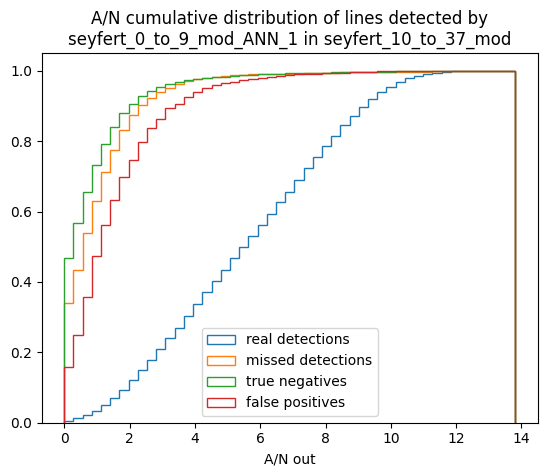

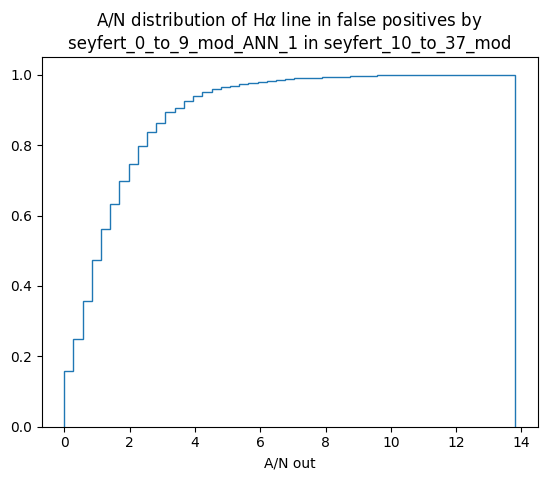

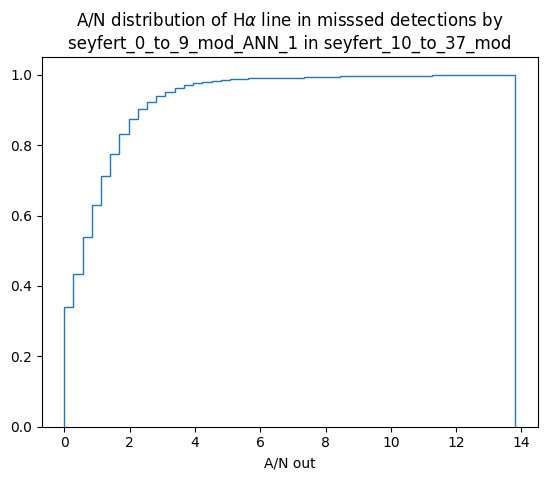

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


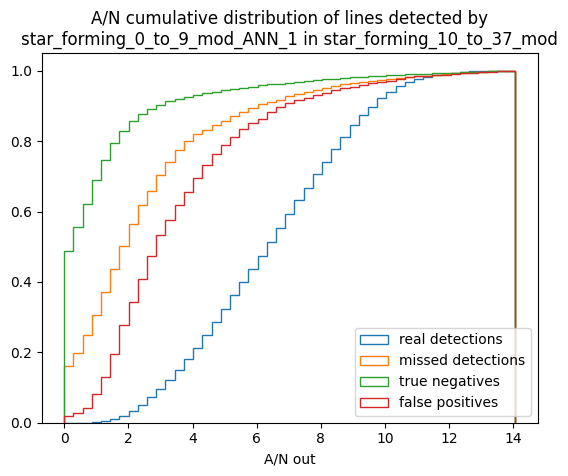

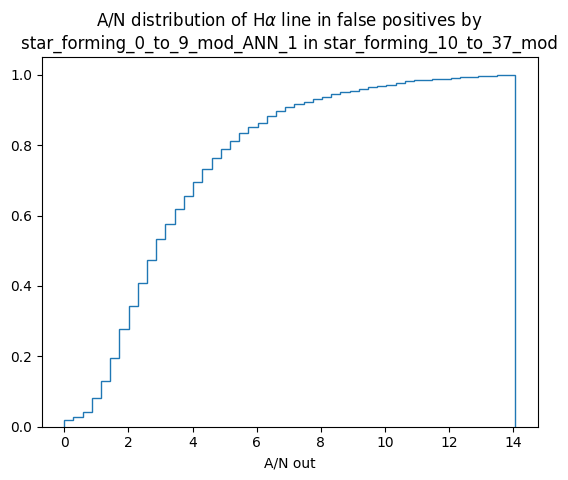

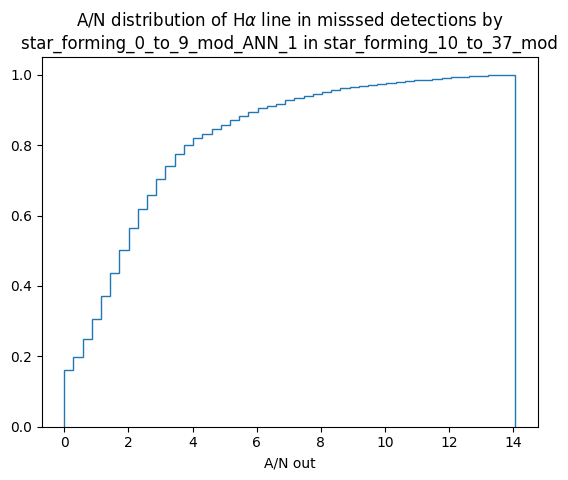

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


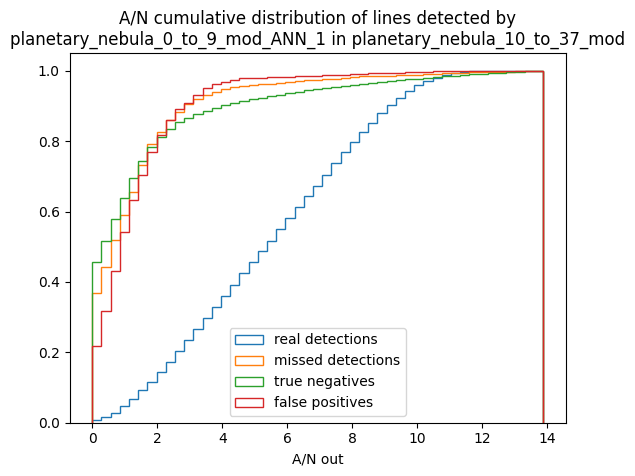

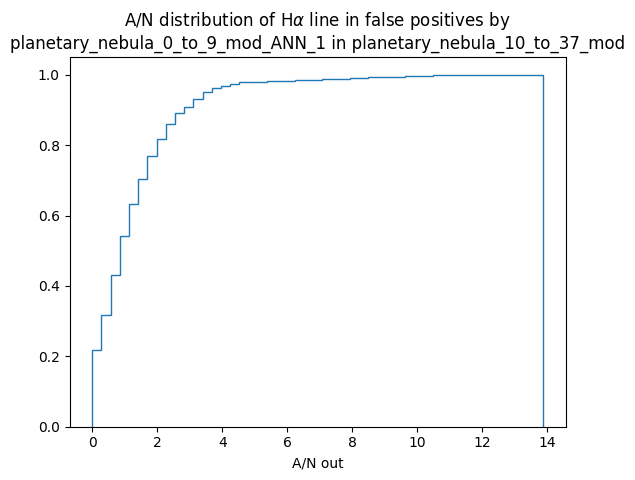

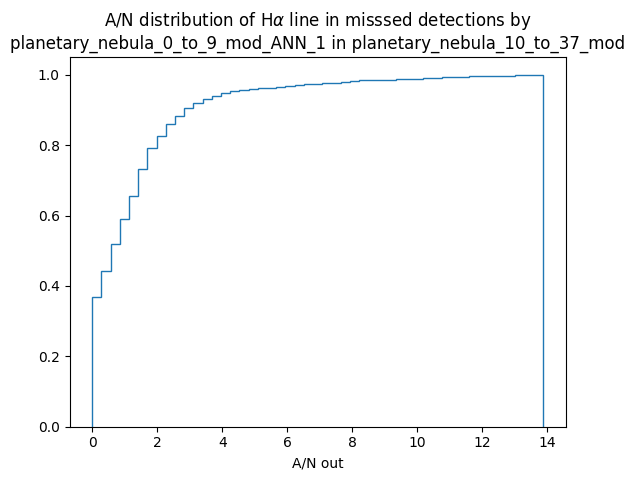

In [ ]:
# At what ANN does it work best
cutoff = cutoffs[min_overall]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    data = np.loadtxt(file)

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]


    test_data = data[:,:-outputs] # The amplitudes
    lines_present = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # The predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    # Separate the lines into the different categories and store AoNs
    lines_present = lines_present.T

    status = lines_present - YPred


    real_det = np.dstack(np.where((status >= 0) & (status <= 1 - cutoff)))[0]
    miss_det = np.dstack(np.where(status > 1 - cutoff))[0]
    nothing = np.dstack(np.where((status > 0 - cutoff) & (status < 0)))[0]
    false_pos = np.dstack(np.where(status <= 0 - cutoff))[0]

    if outputs != 1:
        real_AoNs = data[real_det[:,0], real_det[:,1]]
        miss_AoNs = data[miss_det[:,0], miss_det[:,1]]
        noth_AoNs = data[nothing[:,0], nothing[:,1]]
        false_AoNs = data[false_pos[:,0], false_pos[:,1]]
    else:
        real_AoNs = data[real_det[:,0], 4]
        miss_AoNs = data[miss_det[:,0], 4]
        noth_AoNs = data[nothing[:,0], 4]
        false_AoNs = data[false_pos[:,0], 4]

    # Create histograms
    density = True
    cumulative = True
    no_bins = 50

    hbin = np.linspace(0, np.median(real_AoNs) + 3*np.std(real_AoNs), no_bins)
    plt.hist(real_AoNs, bins=hbin, density=density, label='real detections', histtype='step', cumulative=cumulative)
    plt.hist(miss_AoNs, bins=hbin, density=density, label='missed detections', histtype='step', cumulative=cumulative)
    plt.hist(noth_AoNs, bins=hbin, density=density, label='true negatives', histtype='step', cumulative=cumulative)
    plt.hist(false_AoNs, bins=hbin, density=density, label='false positives', histtype='step', cumulative=cumulative)

    if cumulative == True:
        plt.title(f'A/N cumulative distribution of lines detected by\n{ANN_name} in {test_name}')
    else:
        plt.title(f'A/N distribution of lines detected by\n{ANN_name} in {test_name}')
    plt.xlabel('A/N out')
    plt.legend()
    plt.show()

    # The A/N of the false positives
    false_AoNs = data[false_pos[:,0], 4]

    plt.hist(false_AoNs, bins=hbin, density=density, histtype='step', cumulative=cumulative)
    plt.title(r'A/N distribution of H$\alpha$'+f' line in false positives by\n{ANN_name} in {test_name}')
    plt.xlabel('A/N out')
    plt.show()

    # The A/N of the undetected spectra
    missed_AoNs = data[miss_det[:,0], 4]

    plt.hist(missed_AoNs, bins=hbin, density=density, histtype='step', cumulative=cumulative)
    plt.title(r'A/N distribution of H$\alpha$'+f' line in misssed detections by\n{ANN_name} in {test_name}')
    plt.xlabel('A/N out')
    plt.show()

In [ ]:
for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]


    print(f'{ANN_name} & {np.round(fp[i, mins[i]]*100, 3)} & {np.round(fn[i, mins[i]]*100, 3)} & {cutoffs[mins[i]]} & 408 & 82 & 1000 \\\\ ')

LINER_0_to_9_mod_ANN_1 & 3.779 & 14.225 & 0.92 & 408 & 82 & 1000 \\ 
seyfert_0_to_9_mod_ANN_1 & 3.246 & 12.154 & 0.895 & 408 & 82 & 1000 \\ 
star_forming_0_to_9_mod_ANN_1 & 10.454 & 23.357 & 0.711 & 408 & 82 & 1000 \\ 
planetary_nebula_0_to_9_mod_ANN_1 & 3.496 & 9.35 & 0.736 & 408 & 82 & 1000 \\ 


In [ ]:
fn[0, mins[0]]

0.14225000143051147